# A baseline mock EoR signal simulation with $P(k) = A_0 k^{-2}$

Zachary Martinot and the HERA Validation Team

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-and-Metadata" data-toc-modified-id="Setup-and-Metadata-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup and Metadata</a></span><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Description" data-toc-modified-id="Description-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Software" data-toc-modified-id="Software-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Software</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#General-functions" data-toc-modified-id="General-functions-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>General functions</a></span></li></ul></li><li><span><a href="#Computing-hera_pspec-estimates-from-a-single-realization" data-toc-modified-id="Computing-hera_pspec-estimates-from-a-single-realization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computing <code>hera_pspec</code> estimates from a single realization</a></span></li><li><span><a href="#Initial-comparison-to-input-power-spectrum" data-toc-modified-id="Initial-comparison-to-input-power-spectrum-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial comparison to input power spectrum</a></span><ul class="toc-item"><li><span><a href="#Residuals" data-toc-modified-id="Residuals-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Residuals</a></span></li></ul></li><li><span><a href="#The-aliased-power-spectrum" data-toc-modified-id="The-aliased-power-spectrum-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The aliased power spectrum</a></span><ul class="toc-item"><li><span><a href="#Estimates-compared-to-expected-aliasing" data-toc-modified-id="Estimates-compared-to-expected-aliasing-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Estimates compared to expected aliasing</a></span></li><li><span><a href="#Residuals-using-expected-aliasing" data-toc-modified-id="Residuals-using-expected-aliasing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Residuals using expected aliasing</a></span></li></ul></li><li><span><a href="#Some-ensemble-averaging" data-toc-modified-id="Some-ensemble-averaging-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Some ensemble averaging</a></span><ul class="toc-item"><li><span><a href="#Ensemble-averaged-estimates" data-toc-modified-id="Ensemble-averaged-estimates-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ensemble averaged estimates</a></span></li><li><span><a href="#Enemble-average-residuals" data-toc-modified-id="Enemble-average-residuals-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Enemble average residuals</a></span></li></ul></li><li><span><a href="#Estimates-of-fractional-standard-deviation" data-toc-modified-id="Estimates-of-fractional-standard-deviation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Estimates of fractional standard deviation</a></span></li><li><span><a href="#Redshift-dependent-power-spectrum,-interleaved-time-samples,-and-only-8-hours-of-time-integration" data-toc-modified-id="Redshift-dependent-power-spectrum,-interleaved-time-samples,-and-only-8-hours-of-time-integration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Redshift dependent power spectrum, interleaved time samples, and only 8 hours of time integration</a></span><ul class="toc-item"><li><span><a href="#Residuals" data-toc-modified-id="Residuals-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Residuals</a></span></li></ul></li></ul></div>

## Setup and Metadata

### Abstract

This notebook shows that the simplest `hera_pspec` estimate recovers the power spectrum from realistic visiblities in the most ideal case where the only source of emission on the sky is the cosmological signal and there are no systemic corruptions of the visibility. The visibilities used here will serve as the signal to measured in increasingly realistic simuations that add expected systematic effects. Given that the `hera_pspec` estimate is shown to agree in expectation with the input power spectrum, the ensemble of estimates then provides an estimate of the expected variance which, althouth crude, may be sufficient to be used in assessing the results of future simulations using a single realization. 

We also consider the effect of 1) redefining the power spectrum to have a redshift dependent amplitude and 2) using interleaved time samples in the power spectrum estimate, confirming the expectation that the effects of these changes are negligible at the present tolerances and visibility parameters.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import h5py
import os

import hera_pspec as hps
import pyuvdata

In [2]:
from scipy.special import i0 as bessel_i0

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

Last executed: {{str(datetime.now())}}



- **Major Step Description:** Gaussian cosmological field with known $P(k)$ propagated to visibilities.
- **Minor Variation Description:** The input power spectrum is: $P(k) = A_0 k^{-2}$, with $A_0 =$ `1e1*(1./0.2)**-2.`. The simulated data is for an ideal (coplanar, perfectly redundant antenna positions and beams) 37-element HERA hex array, 8052 time samples over a full sidereal day, 1024 frequency samples in 100-200MHz, and the antenna response given by the Fagnoni simulation of the HERA dipole-feed antenna.
- **Pipelines Tested:** `hera_pspec`
- **Criteria**:
  1. The estimate $\hat{P}(k)$ produced by `hera_pspec` is consistent with a relative difference between $\langle \hat{P}(k) \rangle$ and the input power spectrum $P(k)$ that is $\leq 0.01$.

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. The `hera_pspec` estimates are consistent with the input power spectrum to with 1% for $k > 0.25$ in all sub-bands. For $k < 0.25$ there is discrepency of up to 100% (factor of 2).

Additional notes:

* The cause of the discrepency at low $k$ is unclear at this point. A possible cause is that because the variance of the source field is technically unbounded i.e. $\lim_{k \to \infty} P(k) = \infty$, and since the power spectrum estimates at different $k$ modes are correlated, the discrepency we see is simply a very large, correlated variance, which would in principle average down. This would require more investigation to confirm, but may not be important at the moment since forgrounds will dominate those modes anyway.

* From the ensemble of 50 realizations it is estimated that the fractional deviation of modes $k > 0.2$ is less than or equal to 2%. We can thus expect that power spectrum estimates with integration time reduced to 8 hours will have a fractional deviation not exceeding $\sqrt{3} \cdot
0.02$, or $\sim$3.5%. (quite consistent with Lanman 2019, if i recall correctly)

### Software

HERA software used in this validation test, with associate git commit hash:

* `pyuvdata`: {{pyuvdata.version.git_hash}}
* `hera_pspec`: {{hps.version.git_hash}}

Versions of other software used in this validation test:

* `numpy`: {{np.version.full_version}}

### Data

The following paths reflect the exact locations of all data used in this test:

In [4]:
# Path to data file with a fiducial realization
vis_data_path0 = '/lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5'

assert os.path.exists(vis_data_path0)

In [5]:
# Path to beam normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert os.path.exists(omegas_data_path)

In [6]:
# Saved averaged power spectrum estimates from multiple visibility realizations
uvp_avg_data_path_base = '/lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/uvp_avg_realization_{0}.h5'
N_realizations = 50
uvp_avg_data_paths = [uvp_avg_data_path_base.format(str(rel)) for rel in range(N_realizations)]

assert all([os.path.exists(path) for path in uvp_avg_data_paths])

### General functions

In [7]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path):
    uvd = pyuvdata.UVData()
    uvd.read_uvh5(vis_data_path)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [8]:
# This is the cosmological parameter set in the input simulation
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hps.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                Om_b=Om_b,
                                                Om_c=Om_c,
                                                H0=H0,)
    return hps_cosmo

In [9]:
# Add a new window function to hera_pspec's aipy instance
kaiser6 = lambda x, L: bessel_i0(np.pi * 6 * np.sqrt(1-(2*x/(L-1) - 1)**2)) / bessel_i0(np.pi * 6)
hps.pspecdata.aipy.dsp.WINDOW_FUNC['kaiser6'] = kaiser6

## Computing `hera_pspec` estimates from a single realization

In [10]:
%%time

# Load visibility data for the fiducial realiztion
uvdI = get_VI_data(vis_data_path0)

Telescope RIMEz calculation is not in known_telescopes.


CPU times: user 19min 6s, sys: 1min 50s, total: 20min 57s
Wall time: 5min 46s


In [11]:
cosmo = astropyPlanck15_for_hera_pspec()

In [12]:
# Load beam-dependent normalization data
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()]
    Omegapp = h5f['Omegapp'][()]

In [13]:
hpsb = hps.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, uvdI.freq_array[0], cosmo=cosmo)

In [14]:
# Convert visibility data from Jansky to milikelvin *at the source*
nu_e = 1420405751.7667 # Hz
nu_hz = uvdI.freq_array[0]

# conversion to mK at the observer
Jy_to_mK = hpsb.Jy_to_mK(nu_hz, pol='pI')

# conversion to mK at the source
Jy_to_mK_src = (nu_e/nu_hz) * Jy_to_mK

uvdI.data_array *= Jy_to_mK_src[None,None,:,None]

In [15]:
ds = hps.PSpecData(dsets=[uvdI, uvdI], wgts=[None,None], beam=hpsb)

ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [16]:
# 63 unique baselines, excluding auto-correlation
ant_pairs = [ant_pair for ant_pair in uvdI.get_antpairs() if ant_pair[0] != ant_pair[1]]

# 7 ~15MHz bandwidth spectral windows
edge_inds = [np.argmin(np.abs(nu_hz - nu_i)) for nu_i in 1e6*np.linspace(100.,200.,8, endpoint=True)]
spw_ranges = zip(edge_inds, edge_inds[1:])

In [17]:
%%time
uvp = ds.pspec(ant_pairs, ant_pairs, 
               dsets=(0,1),
               pols=('pI', 'pI'),
               spw_ranges=spw_ranges,
               input_data_weight='identity',
               norm='I',
               taper='blackman-harris',
               verbose=False,
               little_h=False)

CPU times: user 7h 57min 27s, sys: 13min 15s, total: 8h 10min 42s
Wall time: 28min 25s


In [18]:
blpair_group = [sorted(np.unique(uvp.blpair_array))]

uvp_avg = uvp.average_spectra(blpair_groups=blpair_group, time_avg=True, inplace=False)

uvp_avg.fold_spectra()

In [19]:
keys = uvp_avg.get_all_keys()

In [20]:
pspec_est, k_est, k_nyquist = {}, {}, {}

for spw in uvp_avg.data_array.keys():
    pspec_est[spw] = uvp_avg.get_data(keys[spw])[0]
    k_est[spw] = uvp_avg.get_kparas(spw, little_h=False)
    dly = uvp.get_dlys(spw)
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]

        tau_nyquist = np.amax(dly) + ddly/2.
        
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))

    k_nyquist[spw] = np.amax(tau_nyquist)*uvp.cosmo.tau_to_kpara(z_mean, little_h=False)

## Initial comparison to input power spectrum

In [21]:
def true_power_spectrum(k):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6*A0 * k**-2.
    return Pk

In [22]:
for spw in pspec_est.keys():
    print k_est[spw][0]*0.8

0.01722240631022169
0.018338595487806825
0.019392751048085605
0.020259559688128592
0.02135950179695996
0.02227947838420537
0.02316667517448147


Casting complex values to real discards the imaginary part


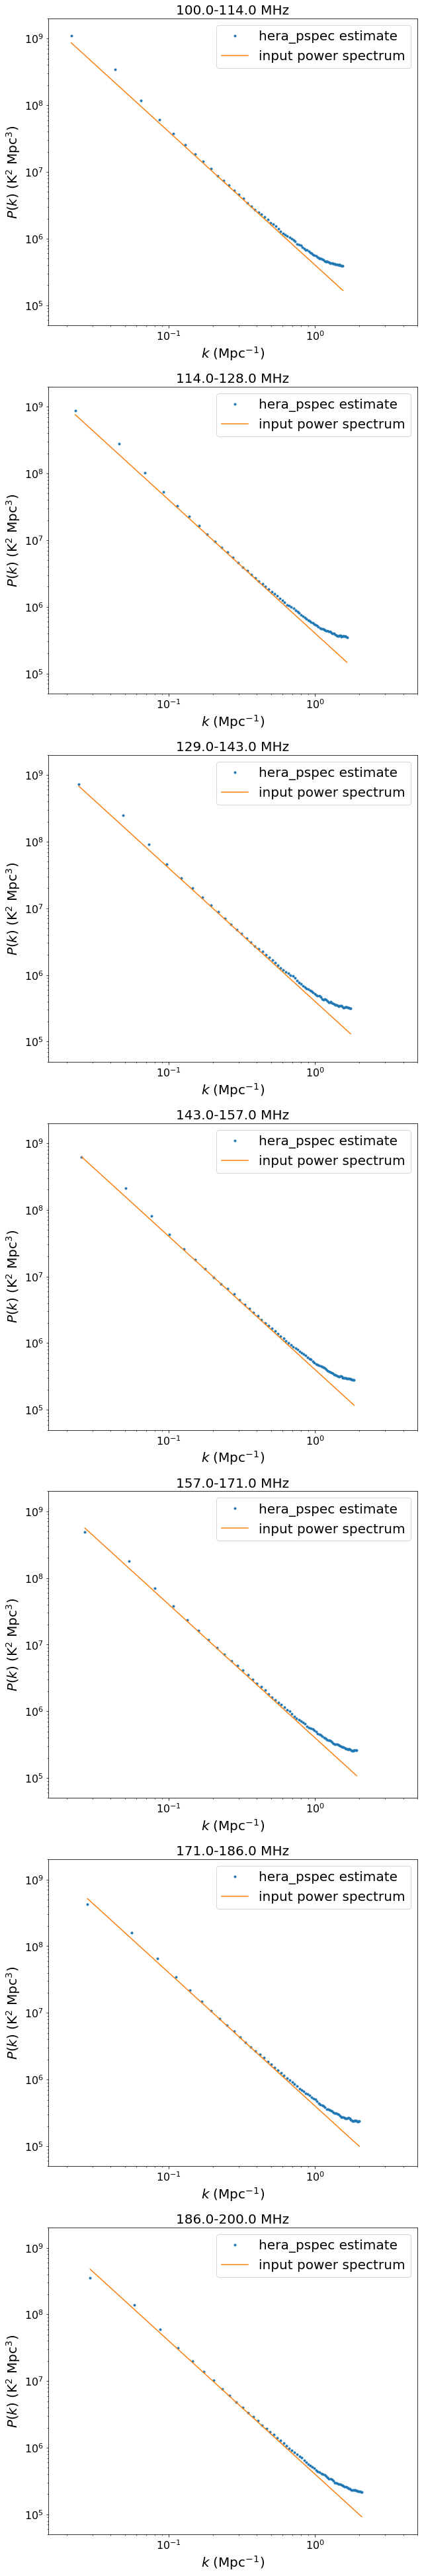

In [23]:
fig = plt.figure(figsize=(10,70))
for spw in pspec_est.keys():
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
    ax.plot(k_est[spw], pspec_est[spw], '.', label='hera_pspec estimate')
    ax.plot(k_est[spw], true_power_spectrum(k_est[spw]), label='input power spectrum')
    
    plt.yscale('log')
    plt.ylim(0.5e5,2e9)
#     plt.xlim(-0.1,2.2)
    plt.xlim(1.5e-2, 5e0)
    plt.xscale('log')
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
#     title_str = r'Redshift: {0}'.format(str(np.around(z_mean,2)))
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'$P(k)$ (K$^2$ Mpc$^3$)', fontsize=20)
    plt.legend(fontsize=20)
    
plt.show()

**Figure 1** | The power spectrum estimates (blue points) for five ~20MHz subbands and the input power spectrum (orange line). The discrepancy is due to aliasing.

### Residuals

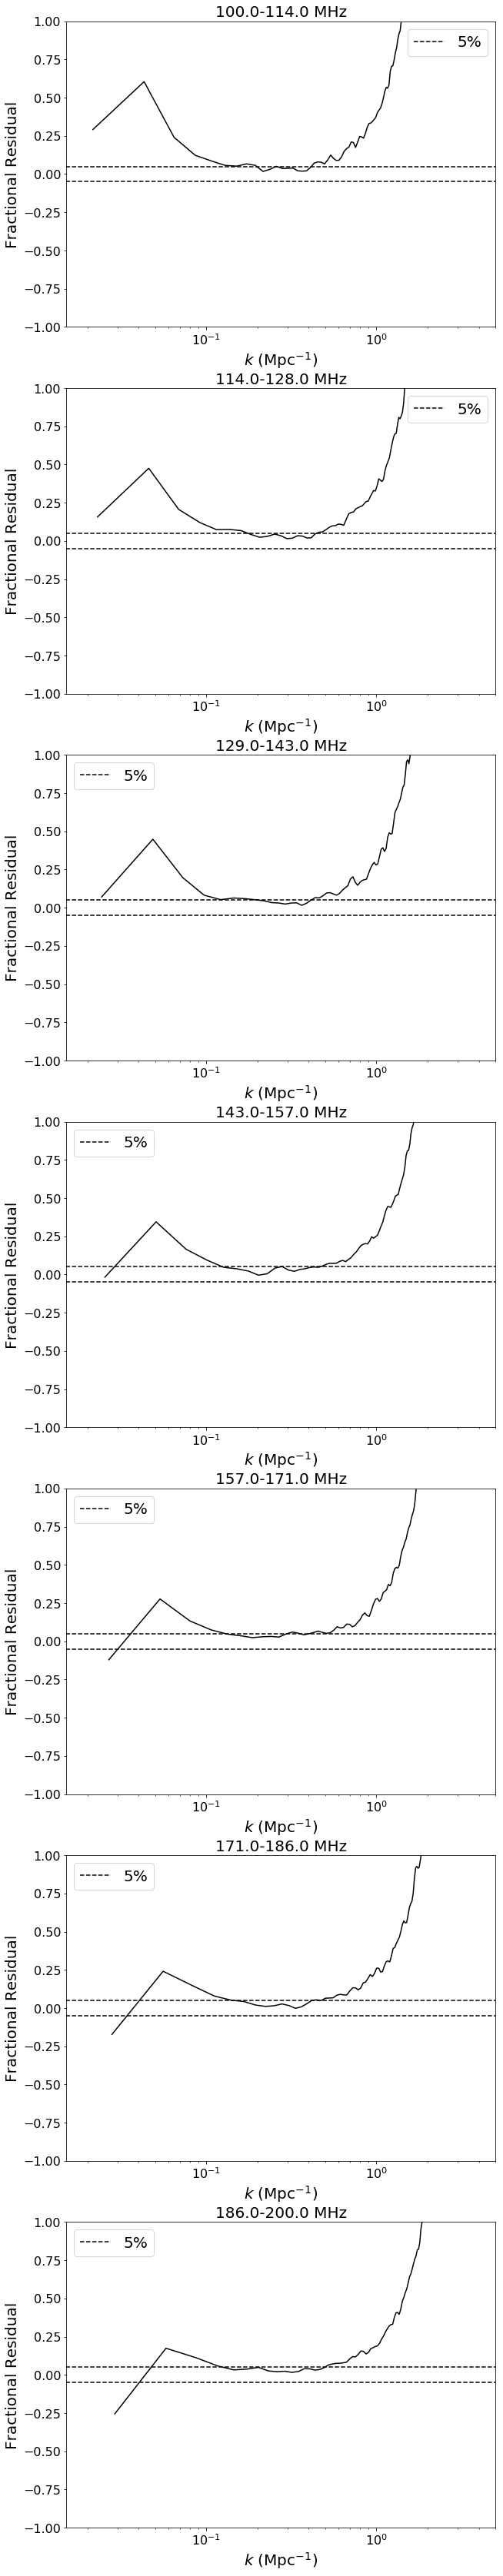

In [24]:
fig = plt.figure(figsize=(10,60))
for spw in pspec_est.keys():
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
    
    truth = true_power_spectrum(k_est[spw])
    res = (pspec_est[spw] - truth)/truth

    ax.plot(k_est[spw], res, '-k')
    
    plt.hlines([-0.05,0.05],xmin=-0.1,xmax=10., linestyle='--', label='5%')

    plt.ylim(-1.,1.)
    
    plt.xscale('log')
    plt.xlim(1.5e-2, 5e0)
    
    plt.legend()
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    
    plt.ylabel('Fractional Residual', fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.legend(fontsize=20)
#     print np.std(all_res[spw].real), np.amax(all_res[spw].real)
plt.show()

**Figure 2** | Fractional residual defined as $$ Residual = \frac{Estimate - Truth}{Truth} = \frac{\hat{P}(k) - P(k)}{P(k)}$$

## The aliased power spectrum

The discrepancy between the true power spectrum and the estimates is due to an aliasing effect. In general, if the power spectrum of a random function is $P(k)$ for $k \in [0, \infty)$ and that function is sampled at a rate $2 k_s$ then there will be aliasing and the power spectrum of the aliased function will be

\begin{align}
Q(k) & = P(k) + \sum_{n=1}^{\infty} P(2 n k_s - k) + P(2 n k_s + k), \text{ for } k \in (0, k_s).
\end{align}

Provided that $P(k)$ tends to zero for $k > k_s$ the aliased power spectrum can be readily computed to whatever tolerence is desired by truncating the above sum at the appropriate $n$.

Because the DFT over uniformly spaced frequency samples $\nu_n$ of the delay transform is a non-uniform DFT in line-of-sight distance $r(\nu)$, this picture of the aliasing is approximate, and strictly speaking there is no Nyquist sampling rate. However, beceause the deviation of $r(\nu)$ from a linear function is small over each sub-band, the discrepency between this non-uniform set of samples $r_n$ and a set of uniformly spaced samples $r_n'$ with seperation $\Delta r' = r_{n+1}' - r_n'$, defined as
\begin{align}
\frac{1}{\Delta r'} = \frac{1}{N-1} \sum_{n=0}^{N-2} \frac{1}{r_{n+1} - r_n}
\end{align}
is negligibly small. We can thus expect the effective power spectrum for each frequency subband to be effectively defined by an average sampling rate
\begin{align}
k_s = \frac{\pi}{\Delta r'} = \frac{\pi}{N-1} \sum_{n=0}^{N-2} \frac{1}{r_{n+1} - r_n}
\end{align}

and we will see below that this approximation is indeed sufficient at the desired tolerance level of the test in this notebook.

In [25]:
# compute the effective Nyquist rates for each frequency subband
r_samples, dr_samples = {}, {}
ks_alt = {}
for spw in uvp_avg.data_array.keys():
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp_avg.freq_array[i0:i1]
    z_s = cosmo.f2z(spw_freqs)
    r_samples[spw] = np.array([cosmo.DC(z, little_h=False) for z in z_s])
    dr_samples[spw] = np.diff(r_samples[spw])
    
    ks_alt[spw] = np.pi*np.mean(1./np.abs(dr_samples[spw]))

In the particular case of the power spectrum of the present simulation we can simplify the expresion for $Q(k)$. Since $P(k) = P(-k) = \frac{A_0}{k^2}$, we obtain

\begin{align}
Q(k) & = \sum_{n=-\infty}^{\infty} P(k + 2 n k_s) \\
& = A_0 \sum_{n=-\infty}^{\infty} \frac{1}{4 k_s^2 (n - a)^2}, \qquad{} a = \frac{k}{2 k_s}
\end{align}


This sum can be computed with the residue summation theorem from complex analysis. The general result is that if $f(z)$ is an analytic function with poles $z_j$ that do not include the integers, then

\begin{align}
\sum_{n=-\infty}^{\infty} f(n) = - \sum_j Res[\pi \cot(\pi z) f(z), z_j].
\end{align}

Let $f(z) = \frac{1}{(z - a)^2}$. Since $ k < k_s$ we have $ 0 < a < \frac{1}{2}$, so $a \notin \mathbb{Z}$, and the residue at $a$ is

\begin{align}
Res[\pi \cot(\pi z) \frac{1}{(z - a)^2}, a] & = \frac{d}{dz} \big( \pi \cot(\pi z) \big) |_{z=a}\\
& = - \pi^2 \csc^2(\pi a)
\end{align}

Thus, the aliased power spectrum is

\begin{align}
Q(k) = A_0 \frac{\pi^2}{4 k_s^2} \csc^2 \bigg( \frac{\pi k}{2 k_s} \bigg), \qquad k \in (0, k_s).
\end{align}

In [26]:
def aliased_power_spectrum(k, k_nyquist):
    A0 = 1e1 * (1./0.2)**-2.
    
    Pk = 1e6*A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k / k_nyquist /2.))**2.
    return Pk

### Estimates compared to expected aliasing

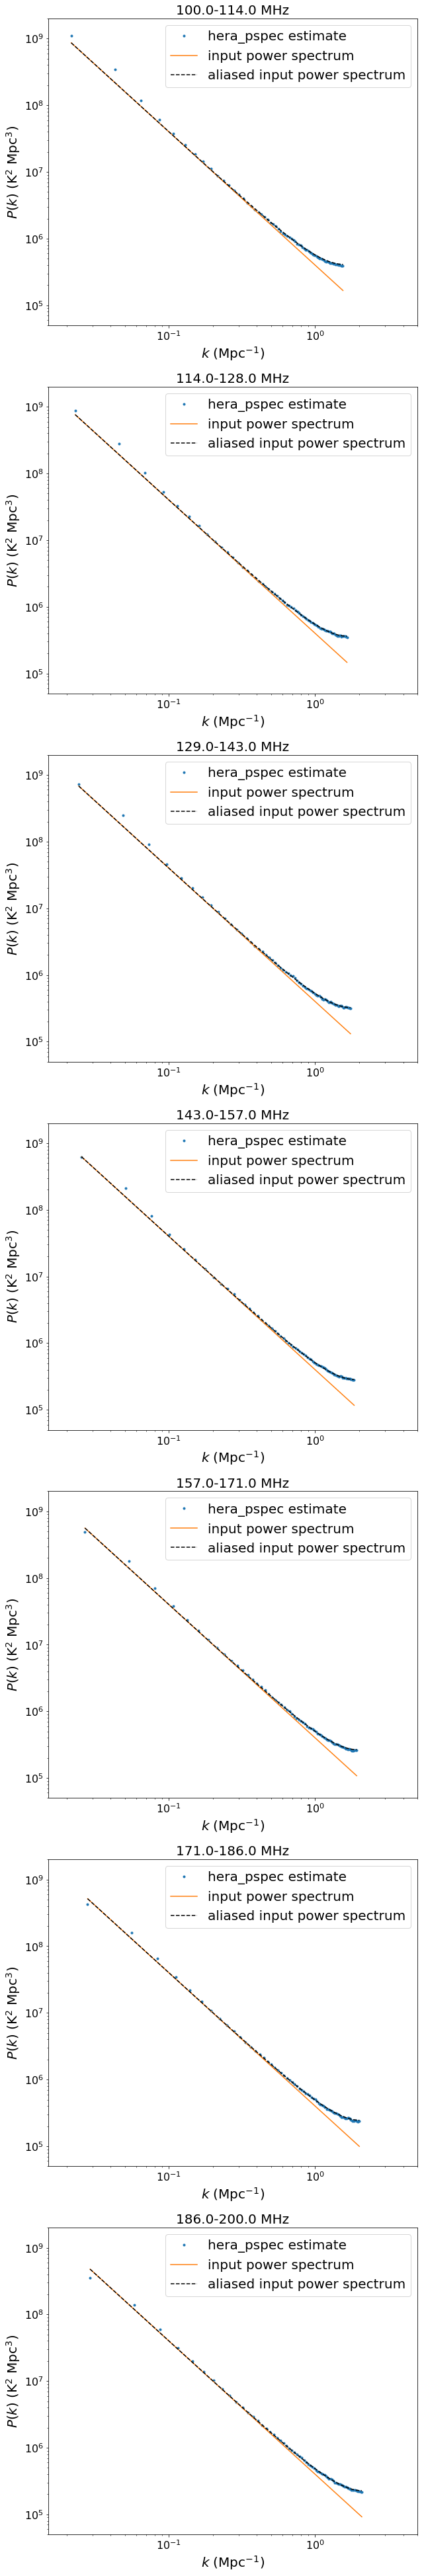

In [27]:
fig = plt.figure(figsize=(10,70))
for spw in pspec_est.keys():
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
    ax.plot(k_est[spw], pspec_est[spw], '.', label='hera_pspec estimate')
    ax.plot(k_est[spw], true_power_spectrum(k_est[spw]), label='input power spectrum')
    ax.plot(k_est[spw], aliased_power_spectrum(k_est[spw], k_nyquist[spw]), '--k', label='aliased input power spectrum')
    
    plt.yscale('log')
    plt.ylim(0.5e5,2e9)
    plt.xscale('log')
    plt.xlim(1.5e-2, 5e0)
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'$P(k)$ (K$^2$ Mpc$^3$)', fontsize=20)
    plt.legend(fontsize=20)
    
plt.show()

### Residuals using expected aliasing

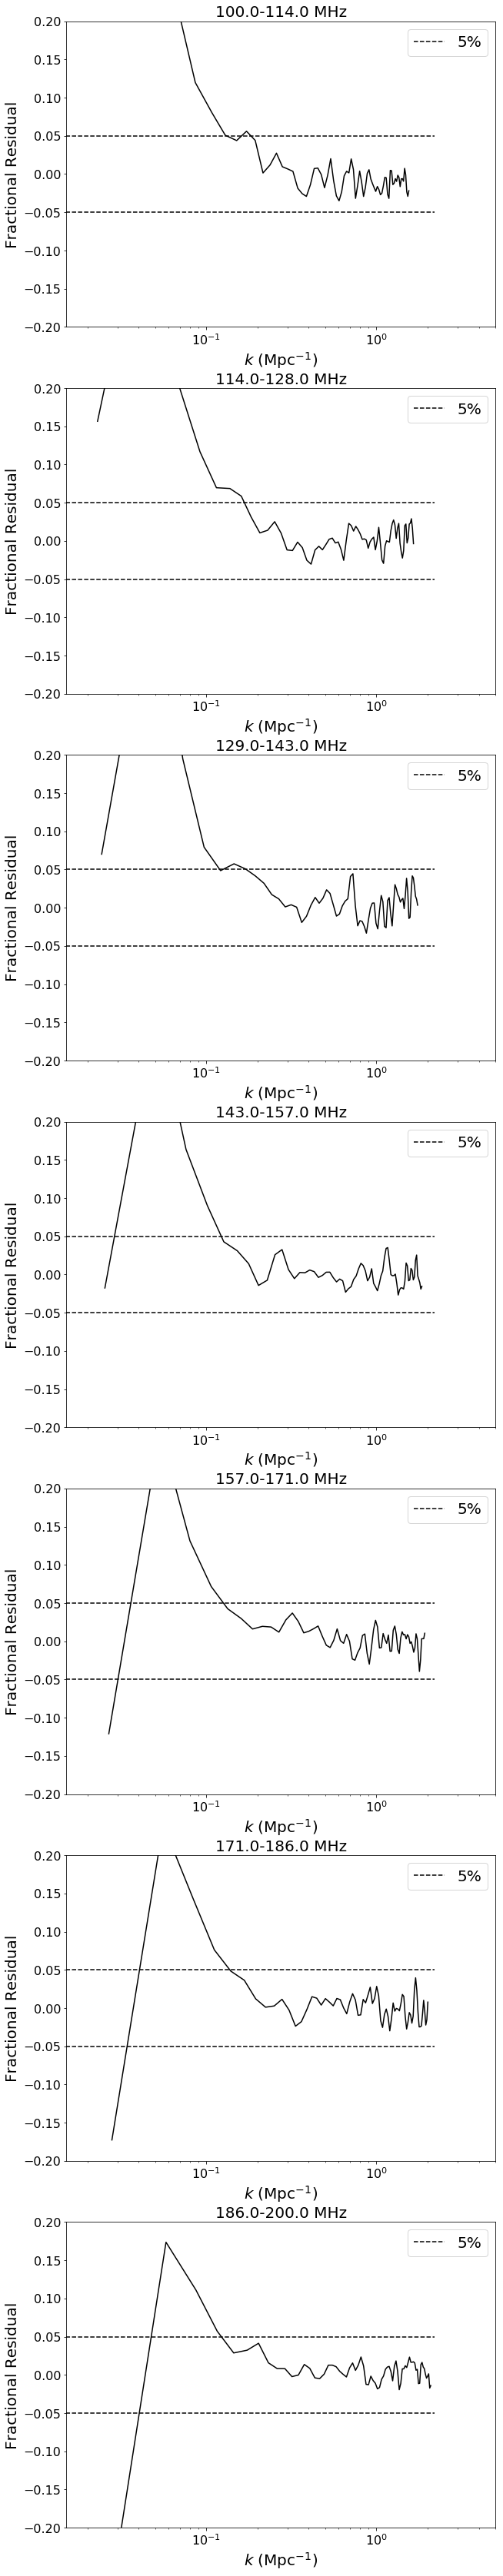

In [28]:
fig = plt.figure(figsize=(10,60))
for spw in pspec_est.keys():
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
    
    aliased_truth = aliased_power_spectrum(k_est[spw], ks_alt[spw])
    res_aliased = (pspec_est[spw] - aliased_truth)/aliased_truth

    ax.plot(k_est[spw], res_aliased, '-k')
    
    plt.hlines([-0.05,0.05],xmin=-0.1,xmax=2.2, linestyle='--', label='5%')

    plt.ylim(-0.2,0.2)
    
    plt.xscale('log')
    plt.xlim(1.5e-2, 5e0)
    
    plt.legend(fontsize=20)
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    
    plt.ylabel('Fractional Residual', fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    
plt.show()

**Figure 3** | Residuals of the estimate relative to the aliased true power spectrum.

##  Some ensemble averaging

Each of these saved `uvpspec` data sets is a new realization of the power spectrum estimate produced in Section 2 i.e. each realiztion is sourced from an independent realization of the cosmological field on the sky, propagated to visibilities.

In [29]:
uvp_avgs = {}

for rel in range(N_realizations):
    path = uvp_avg_data_paths[rel]
    
    uvp_avgs[rel] = hps.uvpspec.UVPSpec()
    uvp_avgs[rel].read_hdf5(path)

In [30]:
keys = uvp_avgs[0].get_all_keys()

In [31]:
pspec_est_rls, k_est = {}, {}

for spw_key in keys:
    spw = spw_key[0]
    
    k_est[spw] = uvp_avgs[0].get_kparas(spw, little_h=False)
    
    Nk = uvp_avgs[0].get_data(spw_key)[0].shape[0]
    pspec_est_rls[spw] = np.zeros((N_realizations, Nk), dtype=np.float64)
    
    for rr in range(N_realizations):
        pspec_est_rls[spw][rr] = uvp_avgs[rr].get_data(spw_key)[0].real

### Ensemble averaged estimates

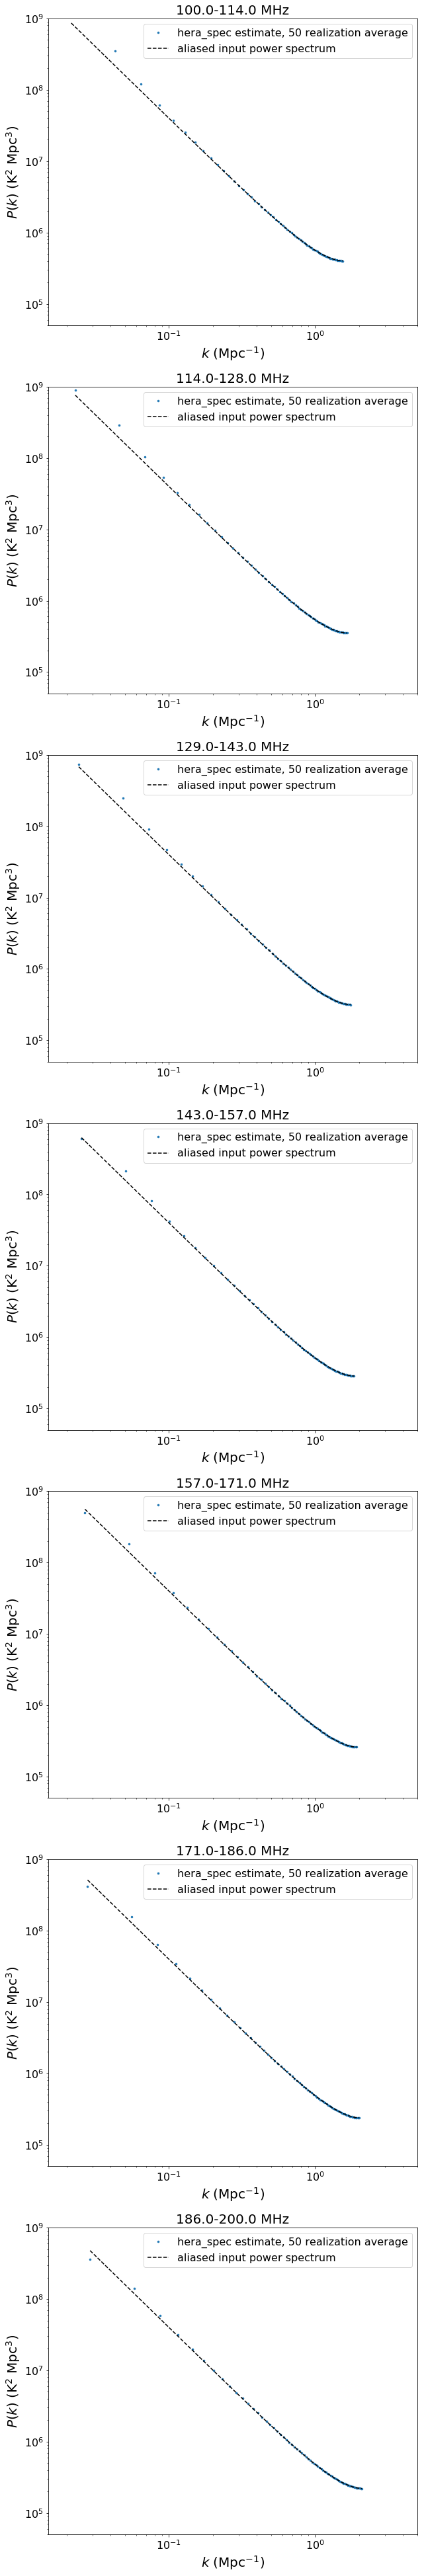

In [32]:
fig = plt.figure(figsize=(10,70))
for spw in pspec_est.keys():
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)

    ax.plot(k_est[spw], np.mean(pspec_est_rls[spw], axis=0), '.', ms=5, label='hera_spec estimate, 50 realization average')
    ax.plot(k_est[spw], aliased_power_spectrum(k_est[spw], ks_alt[spw]), '--k', label='aliased input power spectrum')
    
    plt.yscale('log')
    plt.ylim(0.5e5,1e9)
    
    plt.xscale('log')
    plt.xlim(1.5e-2, 5e0)
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'$P(k)$ (K$^2$ Mpc$^3$)', fontsize=20)
    plt.legend(fontsize=16)
    
plt.show()

**Figure 4** | 

### Enemble average residuals

In [33]:
pspec_res_rls = {}
sample_std = {}

for spw in pspec_est_rls:
    
    aliased_truth = aliased_power_spectrum(k_est[spw], ks_alt[spw])
    
    pspec_res_rls[spw] = np.zeros((N_realizations, pspec_est_rls[spw].shape[1]))
    
    for rr in range(N_realizations):
        pspec_res_rls[spw][rr] = (pspec_est_rls[spw][rr] - aliased_truth)/aliased_truth
        
    sample_std[spw] = np.std(pspec_res_rls[spw], axis=0, ddof=1)

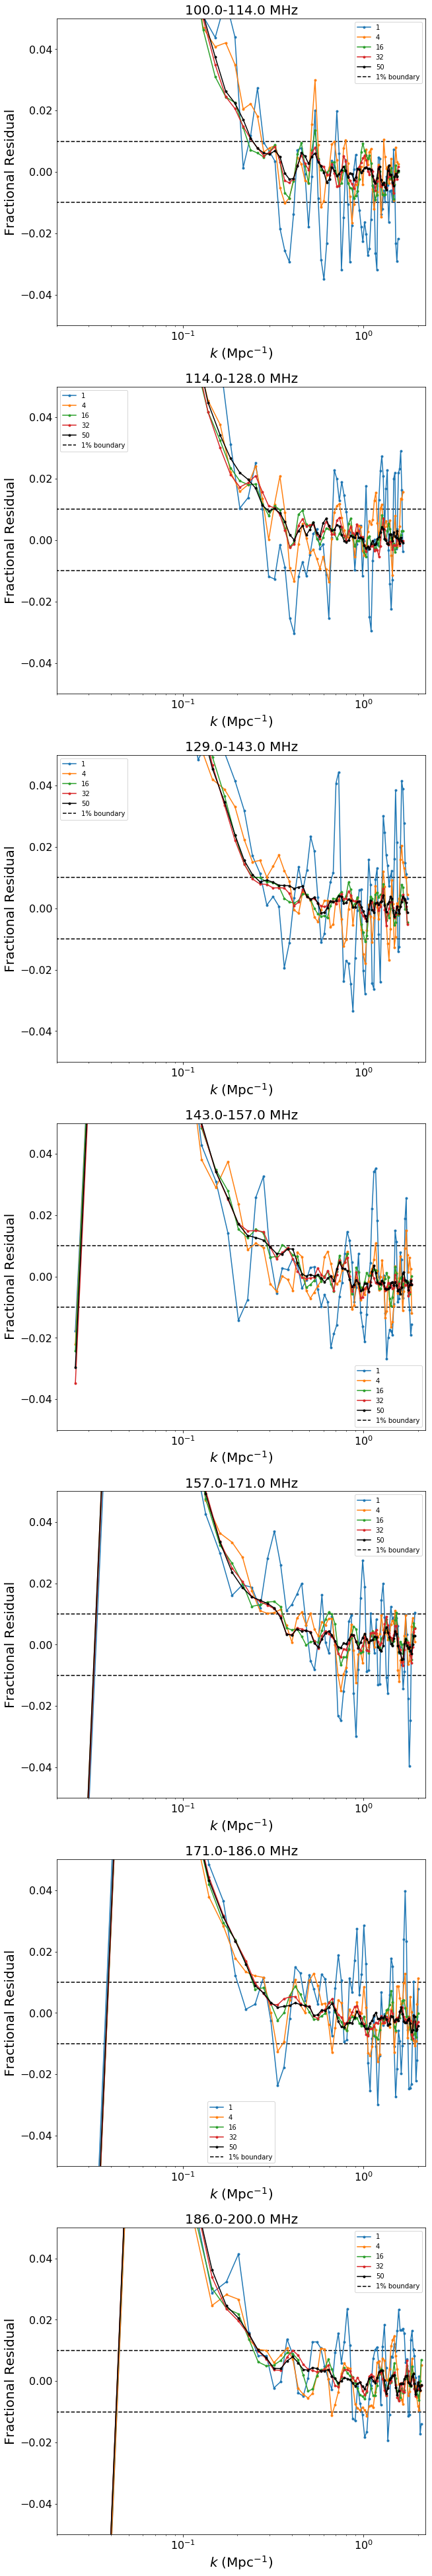

In [34]:
fig = plt.figure(figsize=(10,70))
for spw in pspec_res_rls:
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
        
    for nr in [1,4,16,32]:
        mu_k = np.mean(pspec_res_rls[spw][:nr,:], axis=0)

        ax.plot(k_est[spw], mu_k, '.-', label=str(nr))
        
    mu_k = np.mean(pspec_res_rls[spw], axis=0)

    ax.plot(k_est[spw], mu_k, '.-k', label=str(N_realizations))
    
    plt.hlines([-0.01,0.01],xmin=-0.1,xmax=2.2, linestyle='--', label=r'1% boundary')

    plt.ylim(-0.05,0.05)
    plt.xlim(2.e-2, 2.2)
    plt.xscale('log')
    
    plt.legend()
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    
    plt.ylabel('Fractional Residual', fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    
plt.show()

**Figure 5** |

## Estimates of fractional standard deviation

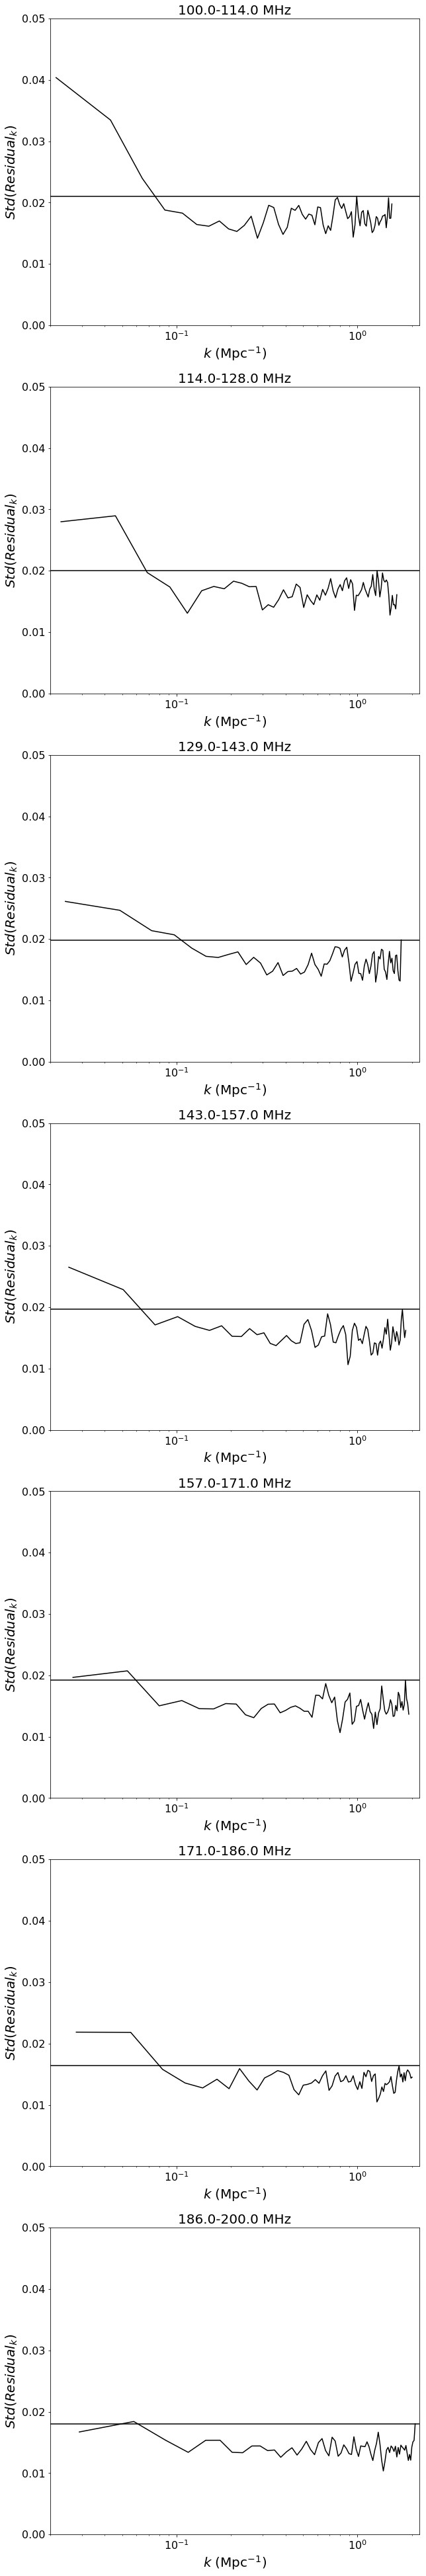

In [35]:
fig = plt.figure(figsize=(10,70))
max_std = {}
for spw in pspec_res_rls:
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
    
    std_k = np.std(pspec_res_rls[spw], ddof=1., axis=0)
    inds_use = np.where(k_est[spw] > 0.2)[0]
    max_std[spw] = np.amax(std_k[inds_use])
    
    ax.plot(k_est[spw], std_k, 'k')
    plt.hlines(max_std[spw], xmin=0.,xmax=10, label='max over k > 0.2')
    
    plt.ylim(0.0,0.05)
    plt.xlim(2.e-2, 2.2)
    plt.xscale('log')
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    
    plt.ylabel(r'$Std(Residual_k)$', fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    
plt.show()

**Figure 6** | Standard deviation estimates of the fractional residuals for each $k$. Horizontal line is the value of the maximum over $k>0.2$



## Redshift dependent power spectrum, interleaved time samples, and only 8 hours of time integration

The cosmological signal visibilities have an input power spectrum
$P(k) = A_0 k^{-2}$, we can redefine the power spectrum to have a redshift dependent amplitude by multiplying the visibility by a factor of $10 \big(\frac{100 MHz}{\nu} \big)^3$ so that the power spectrum is then $P(k,z) = 100 \big(\frac{100 MHz}{\nu(z)}\big)^6 A_0 k^{-2}$.

In [36]:
def redefine_cosmological_signal(uvd):
    """
    Applies a frequency dependent scaling factor to the visibilities that
    changes the input power spectrum as 
    P(k) -> 100 * (100MHz / nu(z))^6 * P(k)
    """
    nu_e = 1420405751.7667 # Hz
    nu_hz = uvd.freq_array[0]
    
    rescaling = 10.*(100e6/nu_hz)**3.
    uvd.data_array *= rescaling[None,None,:,None]
    return

In [37]:
redefine_cosmological_signal(uvdI)

In [40]:
uvdI.vis_units = 'Jy'

In [41]:
# the loaded visibility contains 24 hours of time samples,
# select 8 hours with LST 0-8hr
lst_0_to_8_inds = np.where(np.logical_and(
    uvdI.lst_array <= 8. * np.pi/12.,
    uvdI.lst_array >= 0. * np.pi/12.))
times_use = np.unique(uvdI.time_array[lst_0_to_8_inds])

uvdI.select(times=times_use, inplace=True)

In [42]:
uvd1 = uvdI.select(times=np.unique(uvdI.time_array)[:-1:2], inplace=False)
uvd2 = uvdI.select(times=np.unique(uvdI.time_array)[1::2], inplace=False)

In [43]:
ds = hps.PSpecData(dsets=[uvd1, uvd2], wgts=[None,None], beam=hpsb)

ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [44]:
%%time
uvp = ds.pspec(ant_pairs, ant_pairs, 
               dsets=(0,1),
               pols=('pI', 'pI'),
               spw_ranges=spw_ranges,
               input_data_weight='identity',
               norm='I',
               taper='blackman-harris',
               verbose=False,
               little_h=False)

CPU times: user 1h 19min 59s, sys: 2min 12s, total: 1h 22min 12s
Wall time: 5min 13s


In [45]:
blpair_group = [sorted(np.unique(uvp.blpair_array))]

uvp_avg = uvp.average_spectra(blpair_groups=blpair_group, time_avg=True, inplace=False)

uvp_avg.fold_spectra()

In [46]:
keys = uvp_avg.get_all_keys()

In [47]:
pspec_est, k_est, k_nyquist = {}, {}, {}

for spw in uvp_avg.data_array.keys():
    pspec_est[spw] = uvp_avg.get_data(keys[spw])[0]
    k_est[spw] = uvp_avg.get_kparas(spw, little_h=False)
    dly = uvp.get_dlys(spw)
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]

        tau_nyquist = np.amax(dly) + ddly/2.
        
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))

    k_nyquist[spw] = np.amax(tau_nyquist)*uvp.cosmo.tau_to_kpara(z_mean, little_h=False)

In [48]:
# compute the effective Nyquist rates for each frequency subband
r_samples, dr_samples = {}, {}
ks_approx = {}
for spw in uvp_avg.data_array.keys():
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp_avg.freq_array[i0:i1]
    z_s = cosmo.f2z(spw_freqs)
    r_samples[spw] = np.array([cosmo.DC(z, little_h=False) for z in z_s])
    dr_samples[spw] = np.diff(r_samples[spw])
    
    ks_approx[spw] = np.pi*np.mean(1./np.abs(dr_samples[spw]))

In [52]:
def aliased_power_spectrum(k, ks, z):
    A0 = 1e1 * (1./0.2)**-2. # Kelvin
    
    Pk = 1e6*A0 * (np.pi)**2. * 1./(2. * ks * np.sin(np.pi*k / ks /2.))**2.
    
    nu_e = 1420405751.7667 # Hz
    nu_z = nu_e/(1. + z)
    Pk *= 100.*(100e6/nu_z)**6.
    return Pk

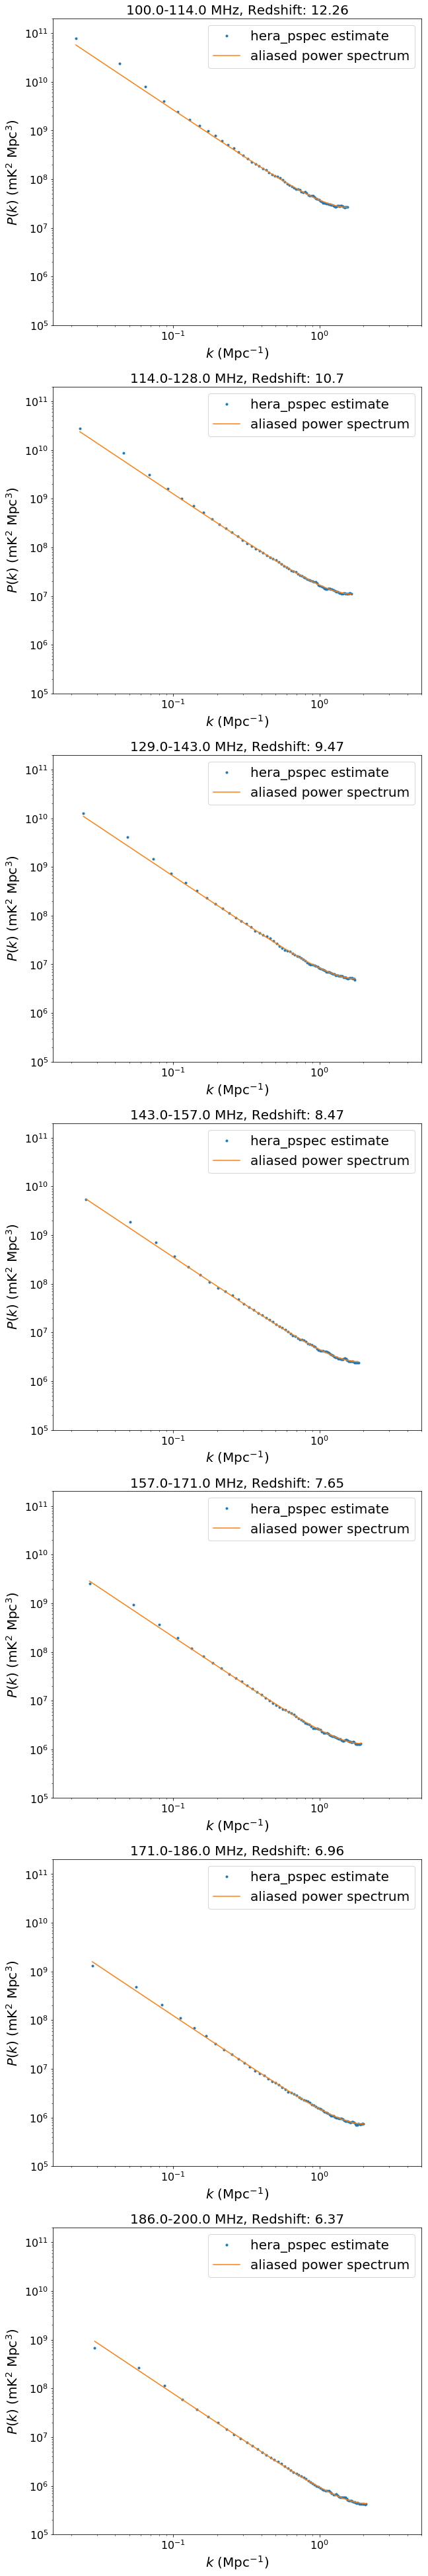

In [55]:
fig = plt.figure(figsize=(10,70))
for spw in pspec_est.keys():
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
        
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
    ax.plot(k_est[spw], np.real(pspec_est[spw]), '.', label='hera_pspec estimate')
    ax.plot(k_est[spw], aliased_power_spectrum(k_est[spw], ks_approx[spw], z_mean), color='tab:orange', label='aliased power spectrum')
    
    plt.yscale('log')
    plt.ylim(1e5,2e11)
#     plt.xlim(-0.1,2.2)
    plt.xlim(1.5e-2, 5e0)
    plt.xscale('log')
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz, Redshift: {2}'.format(str(nu0), str(nu1), str(np.around(z_mean,2)))
    plt.title(title_str, fontsize=20)

    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'$P(k)$ (mK$^2$ Mpc$^3$)', fontsize=20)
    plt.legend(fontsize=20)
    
plt.show()

**Figure 7** | The power spectrum estimates (blue points) for seven ~14MHz subbands using interleaved time samples, and the input power spectrum (orange line) with redshift dependent amplitude.

### Residuals

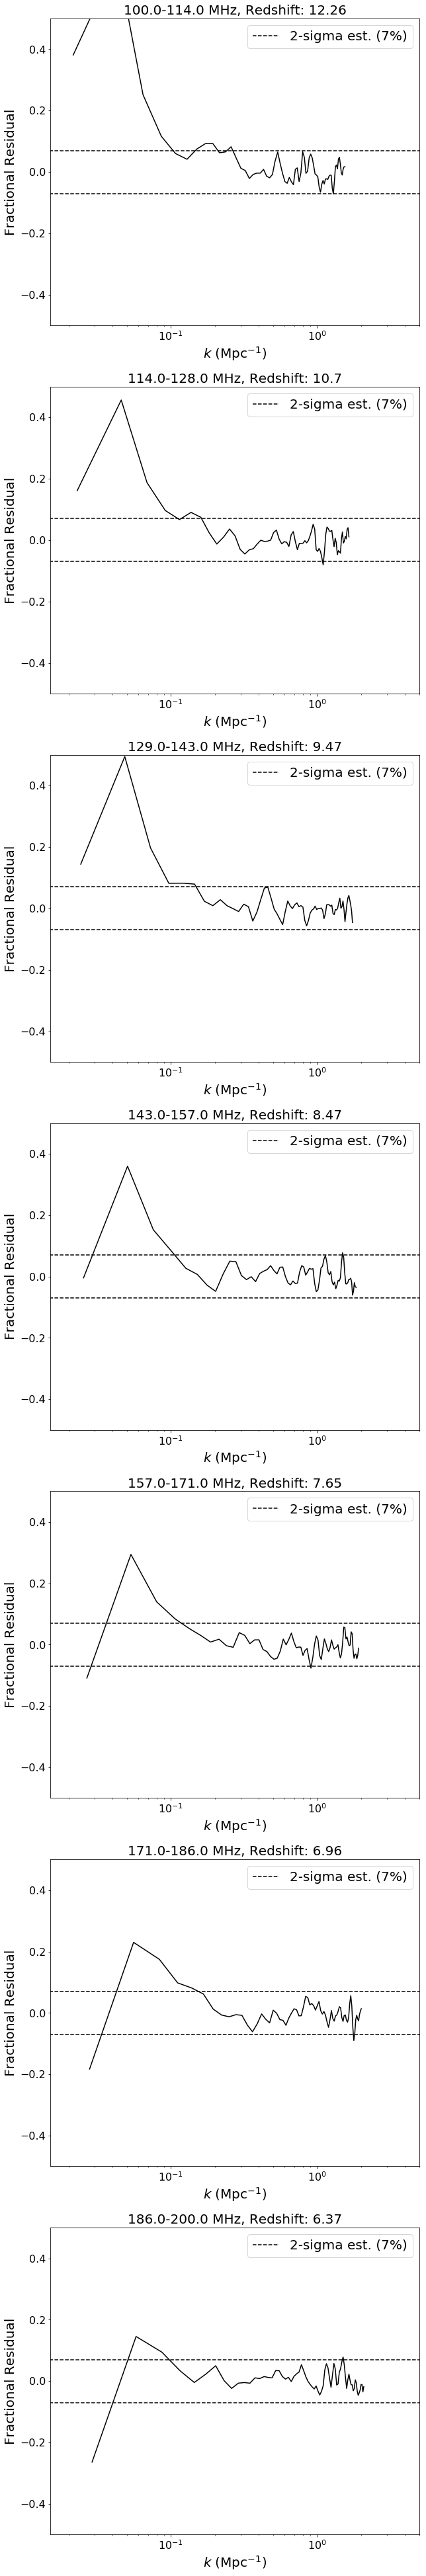

In [54]:
fig = plt.figure(figsize=(10,70))
for spw in pspec_est.keys():
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    ax = fig.add_subplot(7,1,spw+1)
    ax.tick_params(labelsize=16)
    
    truth = aliased_power_spectrum(k_est[spw], ks_approx[spw], z_mean)
    res = (np.real(pspec_est[spw]) - truth)/truth
    
    ax.plot(k_est[spw], res, '-k')
    
    plt.hlines([-0.07,0.07],xmin=-0.1,xmax=10., linestyle='--', label='2-sigma est. (7%)')

    plt.ylim(-0.5,0.5)
    
    plt.xscale('log')
    plt.xlim(1.5e-2, 5e0)
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz, Redshift: {2}'.format(str(nu0), str(nu1), str(np.around(z_mean,2)))
    plt.title(title_str, fontsize=20)

    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'Fractional Residual', fontsize=20)
    plt.legend(fontsize=20)
    
plt.show()

**Figure 8** | Fractional residuals for the redshift dependent power spectrum, and the expected 2-sigma deviation as estimated from the ensemble of realizations in section 6. 